In [1]:
import sys
sys.path.append("..\\scripts\\")
import torch 
from astropy.io import fits
from astropy.visualization import ImageNormalize, AsinhStretch
import numpy as np
import matplotlib.pyplot as plt
from torch.func import vmap, grad
from tqdm import tqdm
from scipy.stats import binned_statistic_2d
import mpol.constants as const
from mpol import coordinates

plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 10
from score_models import ScoreModel, NCSNpp
import json

plt.style.use("dark_background")

from utils import fits_to_tensor, link_function
device = "cuda" if torch.cuda.is_available() else "cpu"

# Importing the models hparams and weights
file = open("../../ncsnpp_ct_g_220912024942/model_hparams.json")
model_hparams = json.load(file)
sigma_min, sigma_max = model_hparams["sigma_min"], model_hparams["sigma_max"]

# Importing the weights
score_model = ScoreModel(checkpoints_directory="../../ncsnpp_ct_g_220912024942")

In [6]:
# Just take the first spectral window: 
data = np.load("../../HTLup_continuum_full.npz")

u = data["uu"]
v = data["vv"]
vis = data["data"]
weight = data["weight"]
vis_per_spw = data["vis_per_spw"]

spw_0 = vis_per_spw[0]
u = u[: spw_0]
v = v[: spw_0]
vis = vis[: spw_0]

uu = np.concatenate([u, u])
vv = np.concatenate([v, v])

vis_re = np.concatenate([vis.real, vis.real])
vis_imag = np.concatenate([vis.imag, vis.imag])
weight_ = np.concatenate([weight, weight])


In [7]:
print(vis.shape)

(321216,)


In [5]:
data["vis_per_spw"]

array([ 321216,  361032,  169120,  594496,  541440,  987840,  987840,
        908040, 3447276, 3447276, 3447276, 1969872, 3532508, 3532508,
       3532508, 2018576], dtype=int64)

In [4]:
data.files

['uu',
 'vv',
 'weight',
 'data',
 'sigma_rescale_spw',
 'vis_per_spw',
 'freq_per_spw']

In [3]:
pixel_scale = 0.0015 # arcsec
npix = 256 # number of pixels in the final image

coords = coordinates.GridCoords(pixel_scale, npix)

u_edges = coords.u_edges
v_edges = coords.v_edges

# # Arcsec to radians: 
# dl = pixel_scale * const.arcsec
# dm = pixel_scale * const.arcsec

# du = 1 / (npix * dl) * 1e-3 # klambda
# dv = 1 / (npix * dm) * 1e-3 # klambda

# u_min = -npix//2 * du 
# u_max = npix//2 * du 

# v_min = -npix//2 * dv
# v_max = npix//2 * dv

# u_edges = np.linspace(u_min, u_max, npix + 1)
# v_edges = np.linspace(v_min, v_max, npix + 1)

Text(0, 0.5, 'v [k$\\lambda$]')

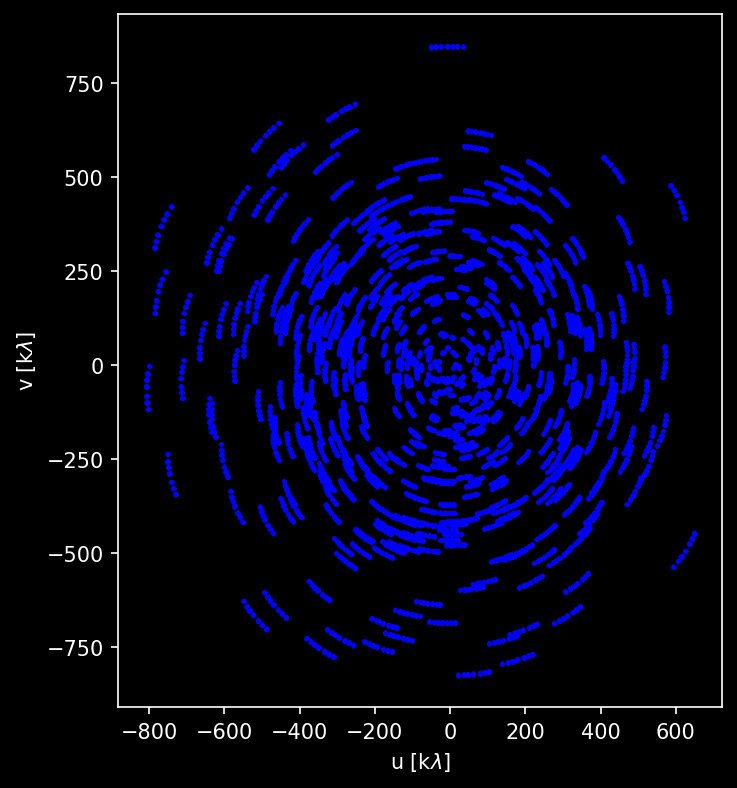

In [8]:
# Plotting the uv coverage: 
figure = plt.figure(figsize = (6, 6))
plt.scatter(u, v, s = 0.5, rasterized = True, color = "b") # Might take some time since there are a lot of uv points 

# for i in range(len(u_edges)): 
#     plt.axvline(u_edges[i])
#     plt.axhline(v_edges[i])

# plt.xlim([u.min(), u.max()])
# plt.ylim([v.min(), v.max()])
plt.gca().set_aspect("equal")
plt.xlabel(r"u [k$\lambda$]")
plt.ylabel(r"v [k$\lambda$]")

In [18]:
pixel_scale = 0.015 # arcsec
img_size = 256
npix = img_size # number of pixels in the final image

# Arcsec to radians: 
dl = pixel_scale * const.arcsec
dm = pixel_scale * const.arcsec

du = 1 / (npix * dl) * 1e-3 # klambda
dv = 1 / (npix * dm) * 1e-3 # klambda

u_min = -npix//2 * du 
u_max = npix//2 * du 

v_min = -npix//2 * dv
v_max = npix//2 * dv

u_edges = np.linspace(u_min, u_max, npix + 1)
v_edges = np.linspace(v_min, v_max, npix + 1)

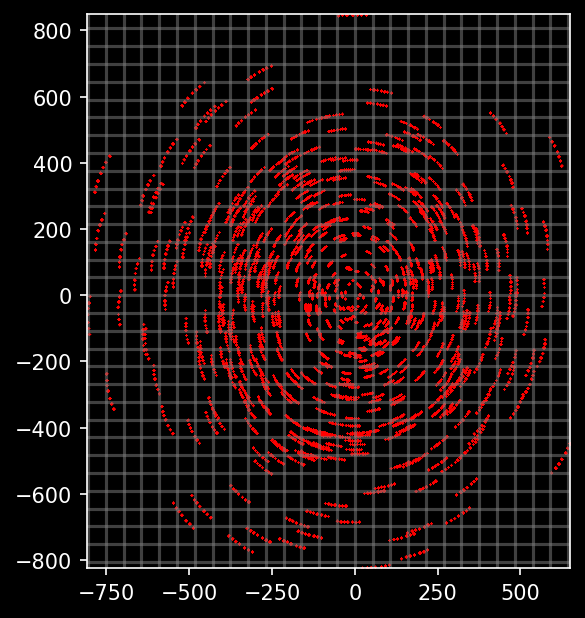

In [19]:
bin_x = u_edges
bin_y = v_edges

plt.scatter(u, v, s=0.5, rasterized=True, linewidths=0.0, c="r")
for x_coord in u_edges: 
    plt.axvline(x = x_coord, color = "gray", linestyle = "-", alpha = 0.5)

for y_coord in v_edges:
    plt.axhline(y =y_coord, color = "gray", linestyle = "-", alpha = 0.5)

plt.xlim([u.min(), u.max()])
plt.ylim([v.min(), v.max()])
plt.gca().set_aspect("equal")

In [21]:
bin_x = u_edges
bin_y = v_edges
vis_gridded_re, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_re, "mean", (bin_y, bin_x))
vis_gridded_img, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_imag, "mean", (bin_y, bin_x))

std_gridded_re, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_re, "std", (bin_y, bin_x))
std_gridded_img, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_imag, "std", (bin_y, bin_x))

count, edgex, edgey, binnumber = binned_statistic_2d(vv, uu, vis_imag, "count", (bin_y, bin_x))

vis_gridded_re[np.isnan(vis_gridded_re)] = 0
vis_gridded_img[np.isnan(vis_gridded_img)] = 0

vis_gridded_re, vis_gridded_img = np.fft.fftshift(vis_gridded_re).flatten(), np.fft.fftshift(vis_gridded_img).flatten()
std_gridded_re, std_gridded_img = np.fft.fftshift(std_gridded_re).flatten(), np.fft.fftshift(std_gridded_img).flatten()
S_grid = vis_gridded_re.astype(bool)
vis_grid = vis_gridded_re + 1j * vis_gridded_img

In [ ]:
def flip(x): 
    return 

In [28]:
std_gridded_re.max()

nan

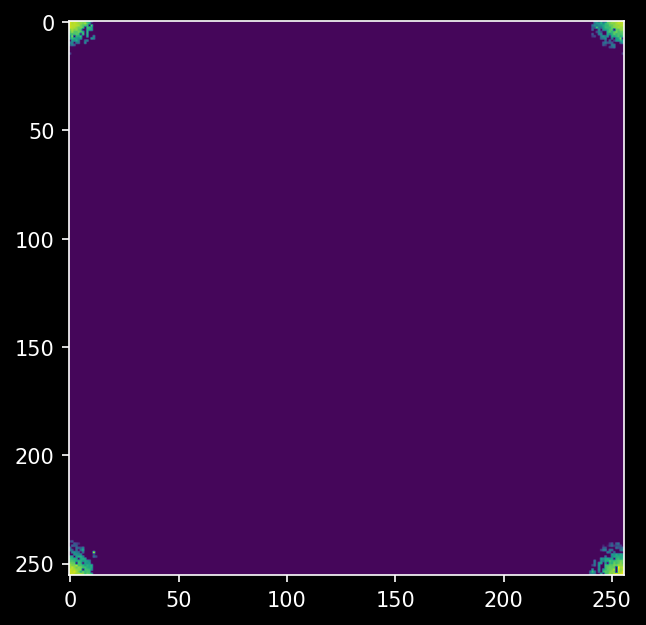

In [31]:
plt.imshow(vis_grid.reshape(img_size, img_size).real)

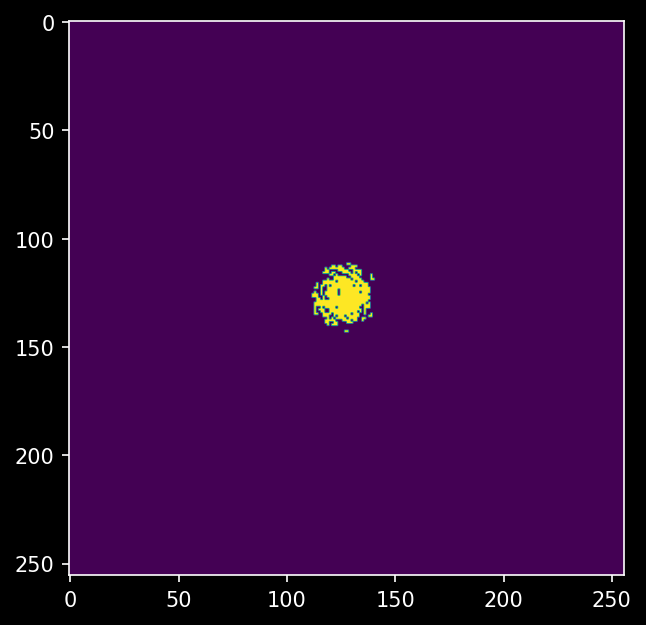

In [27]:
plt.imshow(np.fft.fftshift(S_grid.reshape(img_size, img_size)))

In [120]:
(np.fft.fftshift(count>0.0).flatten() == S_grid).all()

True

In [118]:
np.fft.fftshift(count>0.0)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

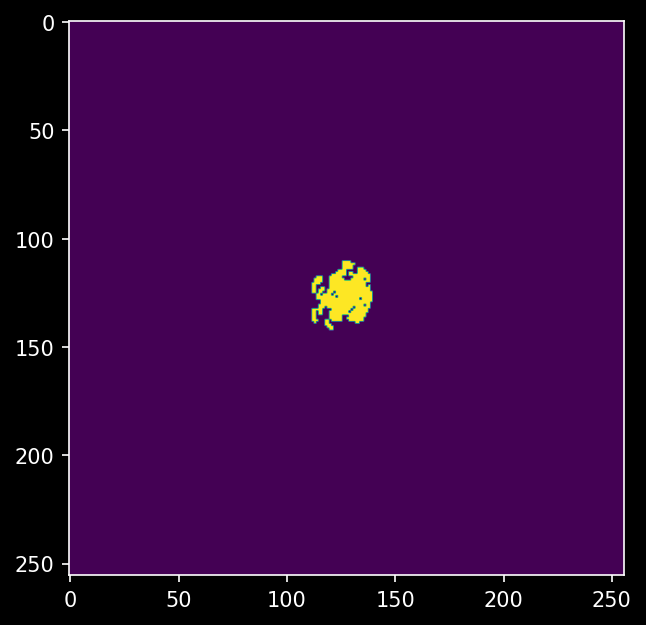

In [108]:
plt.imshow(count>0.0)

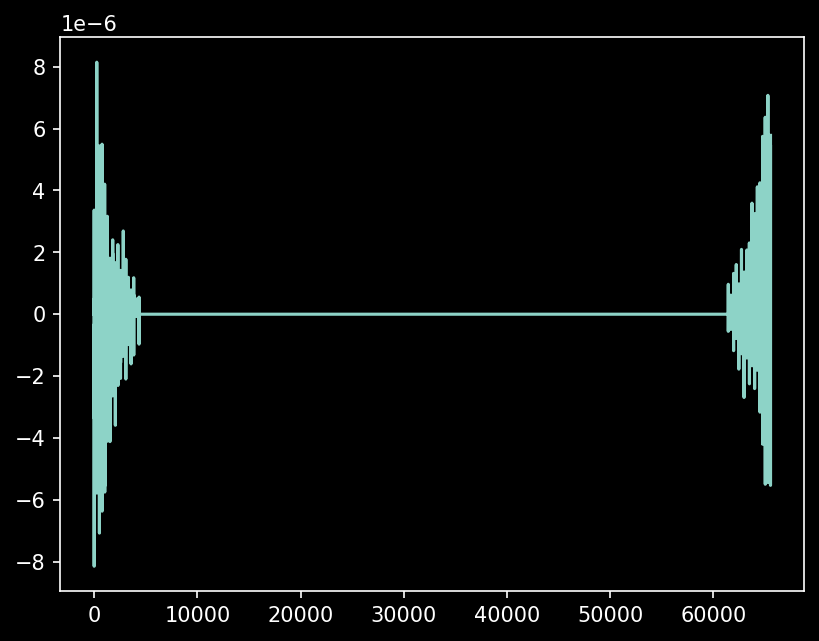

In [25]:
plt.plot(vis_gridded.imag.flatten())

Text(0.5, 0.001, 'Vis gridded')

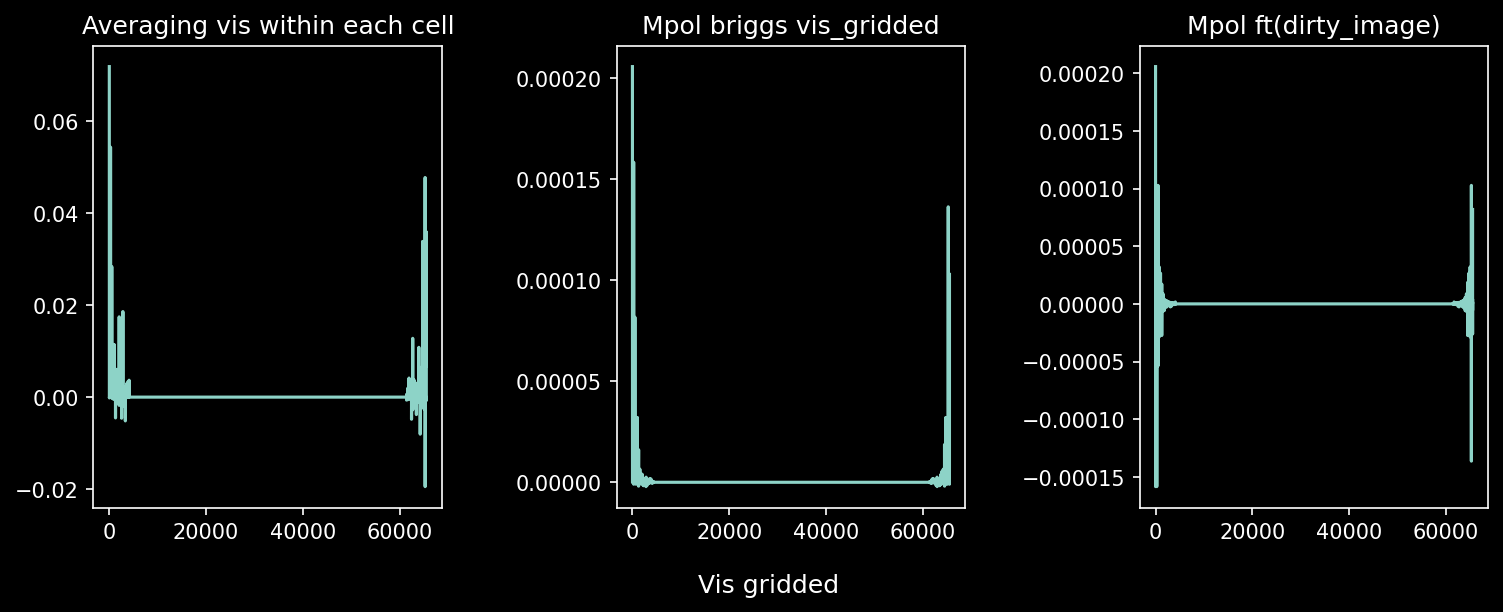

In [67]:
fig, axs = plt.subplots(1, 3, figsize = (4*3, 4))

vis_gridded = imager.vis_gridded * imager.C

axs[0].plot(vis_grid.real.flatten())
axs[0].set(title = "Averaging vis within each cell")

axs[1].plot(vis_gridded.real.flatten())
axs[1].set(title = f"Mpol {weighting} vis_gridded")

axs[2].plot(wrong_vis2.flatten())
axs[2].set(title = f"Mpol ft(dirty_image)")

plt.subplots_adjust(wspace =0.5) 
fig.suptitle("Vis gridded", y = 0.001)

In [68]:
vis_gridded.shape

(1, 256, 256)

In [7]:
header, dirty_image = fits_to_tensor("../../HTLup_continuum0.0015arcsec2.fits")

In [17]:
vis_grid = ft(dirty_image)

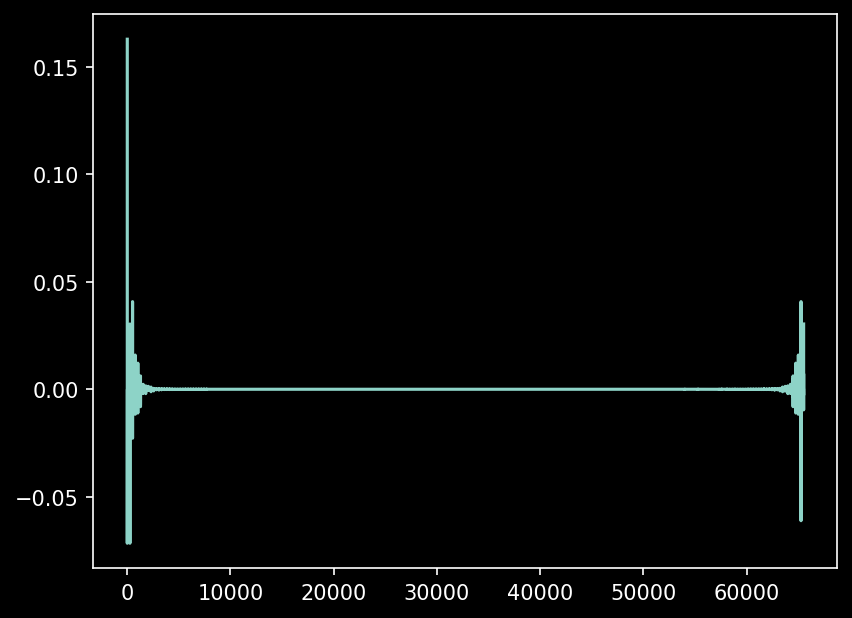

In [20]:
plt.plot(vis_grid.flatten().real.cpu())

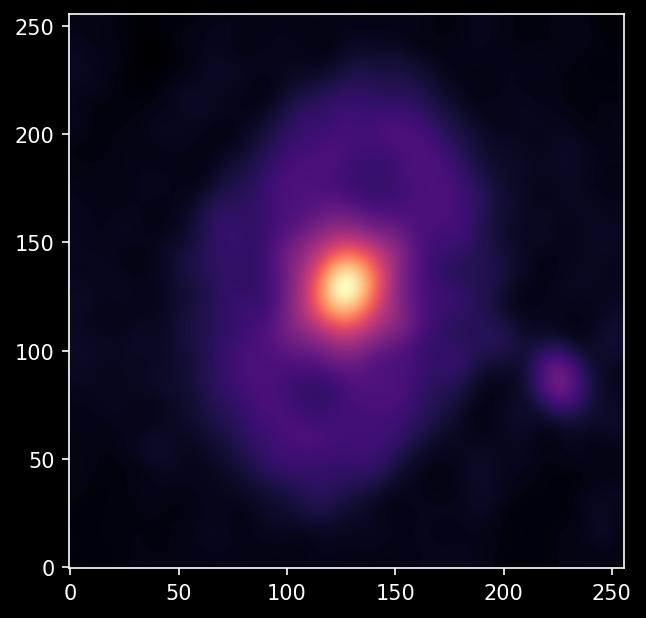

In [15]:
plt.imshow(dirty_image.cpu(), origin = "lower", cmap = "magma")

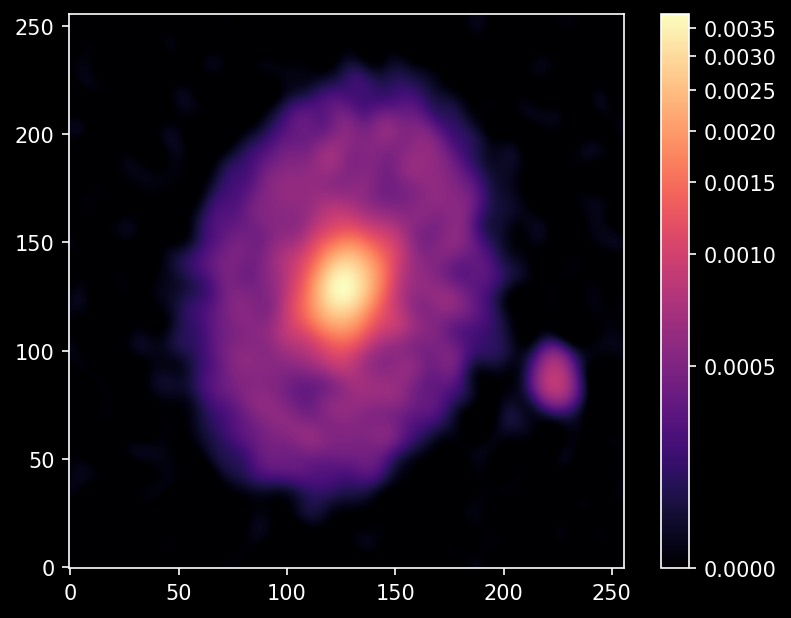

In [99]:
from astropy.visualization import ImageNormalize
norm = ImageNormalize(dirty_image[..., None, None], vmin = 0, stretch = AsinhStretch())
plt.imshow(dirty_image[0], origin = "lower", cmap = "magma", norm = norm)
plt.colorbar()

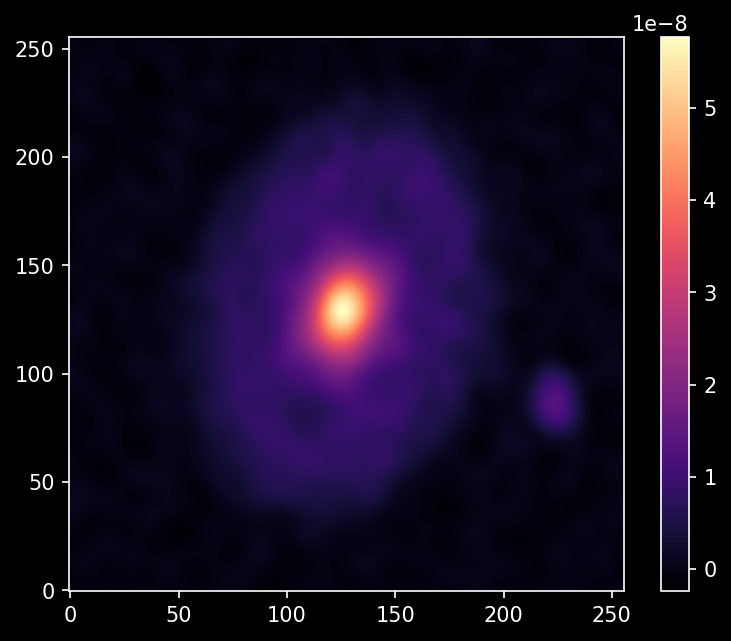

In [91]:

plt.imshow(np.fft.fftshift(imager._fliplr_cube(np.fft.ifft2(vis_gridded))[0]).real, origin = "lower", cmap = "magma", norm = None)
plt.colorbar()

In [11]:
plt.imshow(vis_gridded)

NameError: name 'vis_gridded' is not defined

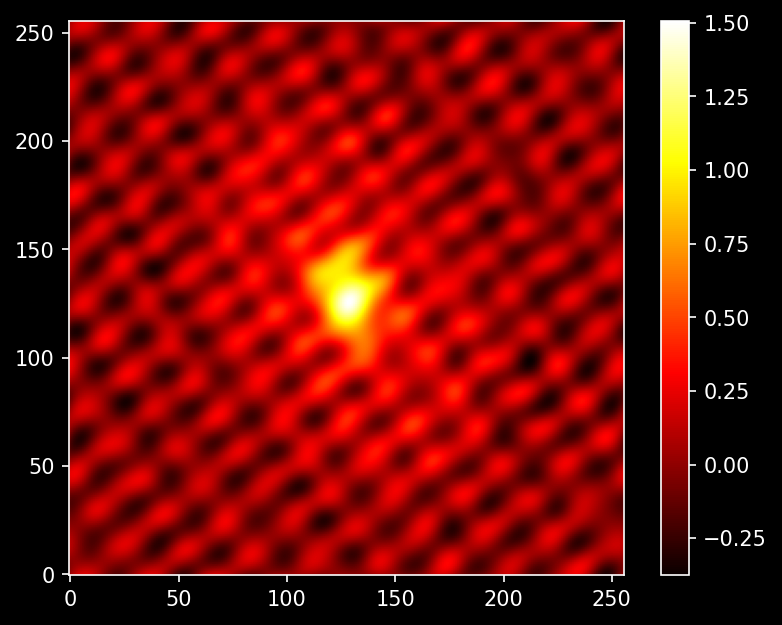

In [11]:
from matplotlib.colors import LogNorm
dirty_image = np.fft.fftshift(np.fft.ifft2(vis_grid.reshape(npix, npix), norm = "forward"))
plt.imshow(dirty_image.real, origin = "lower", cmap = "hot")
plt.colorbar()

In [77]:
img_size = npix

# Concatenate real and imaginary parts of the gridded visibilities and the sigma noise
S = S_grid.flatten()

# Getting rid of all the cells containing no visibilities
y = np.concatenate([vis_gridded_re[S], vis_gridded_img[S]])
sigma_y = np.concatenate([std_gridded_re[S], std_gridded_img[S]])

# Numpy to torch
y = torch.tensor(y).to(device)
sigma_y = torch.tensor(sigma_y).to(device) 

(array([  3.,   0.,   0.,   3.,   9., 639., 326.,  55.,  10.,   1.]),
 array([  0.        ,  11.2916987 ,  22.58339739,  33.87509609,
         45.16679479,  56.45849348,  67.75019218,  79.04189087,
         90.33358957, 101.62528827, 112.91698696]),
 <BarContainer object of 10 artists>)

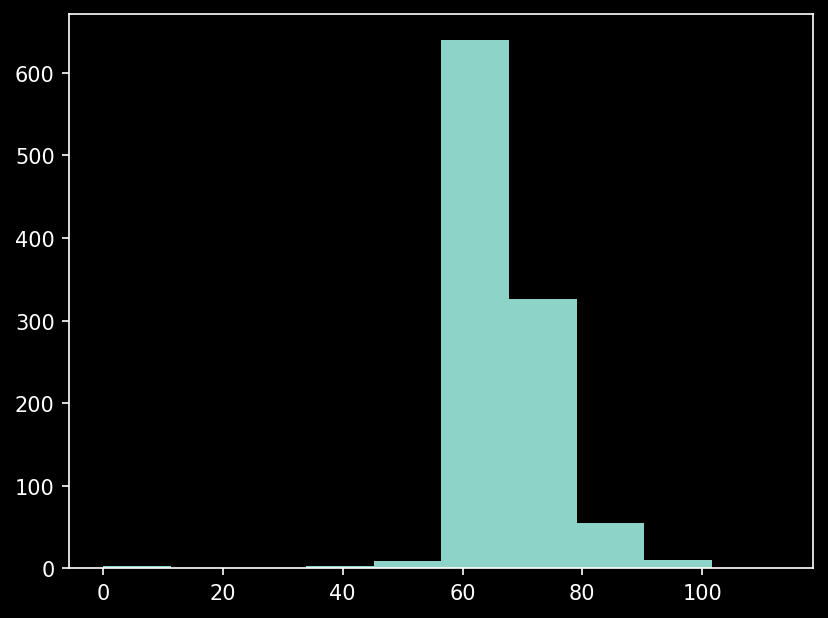

In [59]:
plt.hist(sigma_y.cpu())

In [8]:
vis_grid[0]

(0.07189526513036873-0.0003189096763361255j)

In [10]:
def ft(x): 
    return torch.fft.fft2(x, norm = "ortho")
    
def ift(x): 
    return torch.fft.ifft2(x, norm = "ortho")

In [91]:
def link_function2(x): 
    return (x+1)/2  

In [88]:
#sigma_y = 1e-8 * torch.ones(D).to(device)
#beta = 0
def sigma(t): 
    return sigma_min * (sigma_max/sigma_min) ** t


def model(x):
    x = x.reshape(img_size, img_size) # for the FFT 
    x = link_function2(x) # map from model unit space to real unit space

    # Padding: 
    #pad_size = int((npix - img_size)/2)
    #x = torch.nn.functional.pad(x, (pad_size, pad_size, pad_size, pad_size)) 
    vis_full = ft(x).flatten() 
    vis_sampled = vis_full[S]
    vis_sampled = torch.cat([vis_sampled.real, vis_sampled.imag])
    return vis_sampled


def log_likelihood(y, x, t, sigma_y):
    """
    Calculate the log-likelihood of a gaussian distribution 
    Arguments: 
        y = processed gridded visibilities (real part and imaginary part concatenated)
        x = sky brightness 
        t = diffusion temperature
        A = linear model (sampling function and FT)  
    
    Returns: 
        log-likelihood of a gaussian distribution
    """ 
    y_hat = model(x)
    var = sigma(t) **2 / 2 + sigma_y**2
    log_prob = -0.5 * torch.sum((y - y_hat)**2 / var)
    return log_prob


# GIVE THE GOOD COVARIANCE MATRIX
def score_likelihood(x, t): 
    x = x.flatten(start_dim = 1) 
    return vmap(grad(lambda x, t: log_likelihood(y, x, t, sigma_y)))(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    x = x.reshape(-1, 1, img_size, img_size)
    return score_model.score(t, x).flatten(start_dim = 1) + score_likelihood(x, t) 

k = torch.randn([1, img_size ** 2]).to(device) 
t = torch.ones([1]).to(device)

print((torch.sum(score_likelihood(k, t)**2))**0.5)
print(score_posterior(k, t))

tensor(0.0005, device='cuda:0')
tensor([[ 0.0010,  0.0015, -0.0048,  ...,  0.0034,  0.0058, -0.0007]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [89]:
def g(t): 
    return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))
def pc_sampler(num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_pred_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(x, t)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
            
    return link_function(x_mean)

def euler_sampler(num_samples, num_steps, score_function, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = sigma_max * torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_steps - 1)): 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return link_function(x_mean)

pred = 500
corr = 100
snr = 1e-2
samples = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = img_size)
#samples = pc_sampler(num_samples = 1, num_pred_steps = pred, num_corr_steps = corr, snr = snr, score_function = score_posterior, img_size = img_size)

100%|██████████| 499/499 [02:07<00:00,  3.90it/s]


True


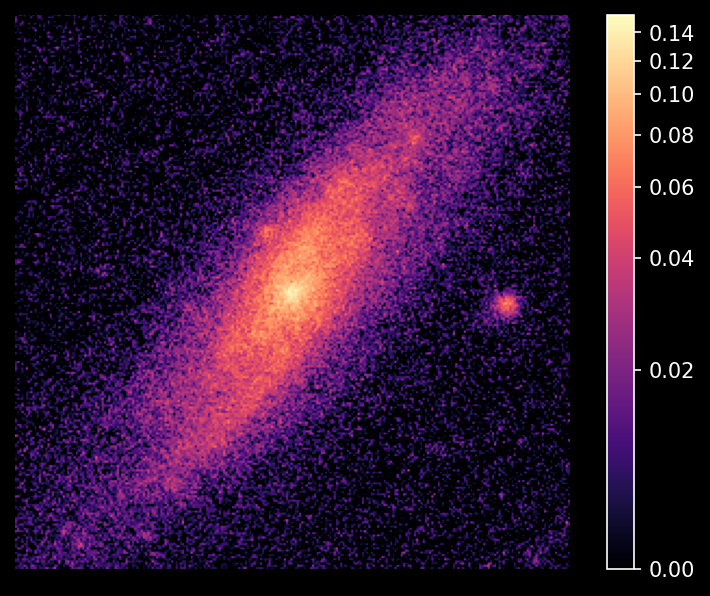

In [90]:
norm = True
save = False
n_images = len(samples)
grid_size = int(n_images**0.5)
if n_images != 1:
    fig, axs = plt.subplots(grid_size, grid_size, figsize = (5, 5))
    norm = ImageNormalize(dirty_image[..., None, None].cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    k = 0
    for i in range(grid_size):
        for j in range(grid_size): 
            im = axs[i, j].imshow((samples[k]).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
            axs[i, j].axis("off")
            #if k==0: 
                #plt.colorbar(im)
            k+=1
else: 
    print(norm)
    if norm:
        save_path = f"../../images/HTLup_pad{npix}norm.jpeg"
        norm = ImageNormalize(samples.cpu().numpy(), vmin = 0, stretch = AsinhStretch())
    else: 
        save_path = f"../../images/HTLup_pad{npix}nonorm.jpeg"
        norm = None
    plt.imshow((samples).cpu().reshape(img_size, img_size), cmap = "magma", norm = norm, origin = "lower")
    plt.axis("off")
    plt.colorbar()
if save: 
    plt.savefig(save_path, bbox_inches = "tight", pad_inches = 0.1)

In [92]:
obs = model(samples)

[Text(0.5, 1.0, 'Model obs')]

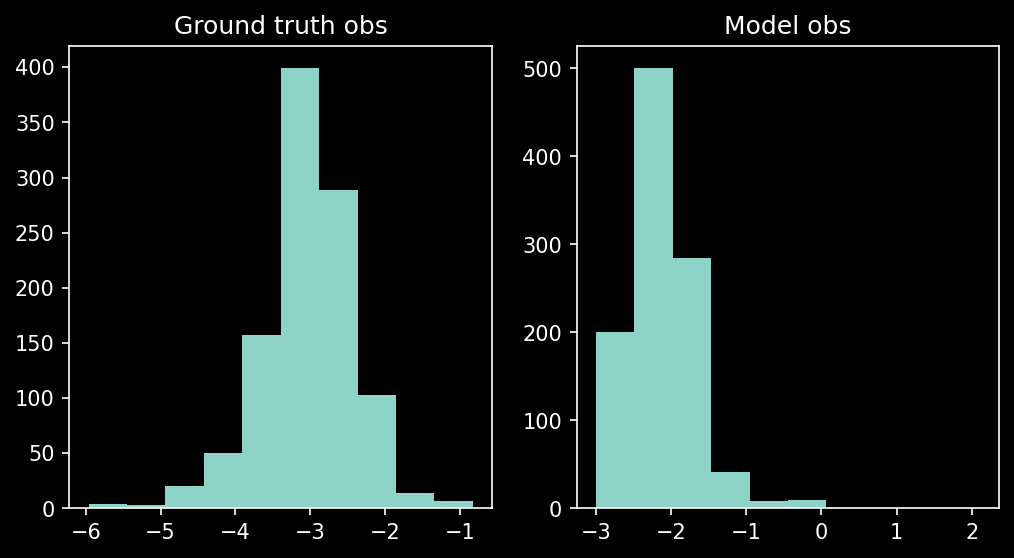

In [96]:
fig, axs = plt.subplots(1, 2, figsize = (2 * 4, 4))
axs[0].hist(np.log10(y.cpu().abs()))
axs[0].set(title = "Ground truth obs")
axs[1].hist(np.log10(obs.cpu().abs() + 1e-3))
axs[1].set(title = "Model obs")

In [100]:
sigma_y.min()

tensor(0., device='cuda:0', dtype=torch.float64)

ValueError: supplied range of [-inf, inf] is not finite

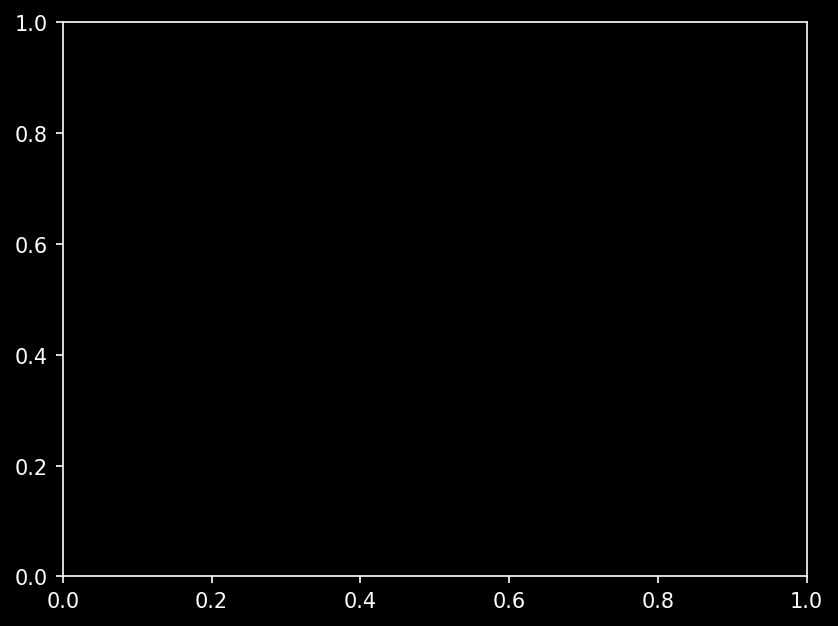

In [99]:
residuals = y - obs
plt.hist((residuals / sigma_y).cpu() )

(array([  1.,   4.,  11., 130., 627., 238.,  28.,   6.,   0.,   1.]),
 array([-6.        , -5.18881798, -4.37763643, -3.56645441, -2.75527263,
        -1.94409084, -1.13290906, -0.32172719,  0.48945466,  1.30063653,
         2.11181831]),
 <BarContainer object of 10 artists>)

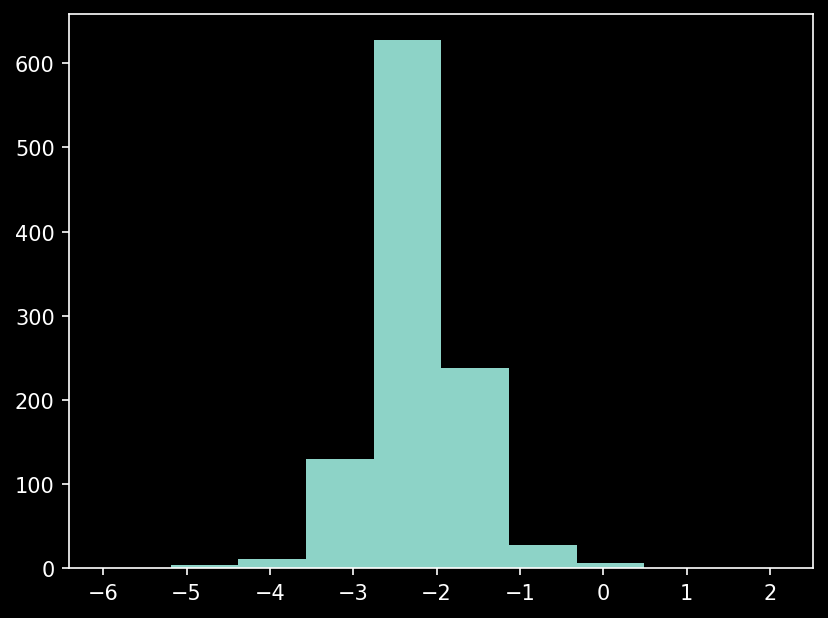

In [94]:
plt.hist(np.log10(obs.cpu().abs()+ 1e-6))